# Bookstore Sales Cleaner & Analyzer

## Context:
You’ve received a month of raw sales data from a small bookstore. Each record lists the transaction ID, book title, category, sale amount, and a few corrupted or missing entries. You’ll clean, organize, and analyze this dataset — applying structured error handling, conditional feature creation, and tidy reshaping of data.

## Objectives

* Load and inspect a messy CSV dataset.
* Handle missing or invalid data safely using try/except and pandas validation.
* Create a new feature using conditional logic (e.g., revenue tiers).
* Reshape and summarize data by category for visualization.
* Generate a Matplotlib bar plot summarizing total sales by category.

## Core Tasks

1. Load & Validate File

    * Try to load sales_data.csv.
    * If the file is missing, print a custom error and safely exit.
    * Otherwise, generate the data.

2. Inspect & Clean

    * Display info and detect missing or malformed entries in key columns (SaleAmount, Category).
    * Convert sale amounts to numeric, coercing invalid entries to NaN and filling with the median.

3. Feature Engineering

    * Create a new column RevenueTier using conditional logic:
        * “Low” for sales < 20
        * “Medium” for 20–50
        * “High” for >50

4. Reshape Data

Use a pivot table or groupby to summarize total sales by Category and RevenueTier.

5. Visualize

Plot total sales per category using a simple Matplotlib bar chart with proper titles and axis labels.

## Optional Stretch Goal

Add an “average sale per category” column and overlay it as a horizontal line on the plot.

## Load libraries

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt
import seaborn as sns

## Generate data

In [3]:
random.seed(42)
np.random.seed(42)

n = 120
start_date = datetime(2025, 10, 1)
dates = [start_date + timedelta(days=int(x)) for x in np.random.randint(0, 31, size=n)]

categories = ["Fiction", "Non-Fiction", "Children", "Comics", "Sci-Fi", "History", "Poetry"]
titles_pool = {
    "Fiction": ["The Last Orchard", "Blue Rivers", "Autumn Glass", "Silent Echoes"],
    "Non-Fiction": ["Thinking Clearly", "Habits of Insight", "Deep Workflows", "Courage to Inquire"],
    "Children": ["Moonlight Friends", "Pocket Zoo", "Little Explorers", "Rainy Day Games"],
    "Comics": ["Night Sentinel #1", "City of Masks #3", "Riftwalker #7", "Crimson Sketches"],
    "Sci-Fi": ["Stars Beyond", "Quantum Harbor", "The Aluminum Sky", "Terraformers"],
    "History": ["Empire and Dust", "Roads of Time", "Queens and Quarrels", "Frontiers"],
    "Poetry": ["Hymns of Dawn", "Paper Flights", "Sealetters", "Sunlit Rooms"],
}

base_price = {
    "Fiction": 24.99, "Non-Fiction": 29.99, "Children": 14.99,
    "Comics": 6.99, "Sci-Fi": 27.49, "History": 31.99, "Poetry": 19.99
}

rows = []
for i in range(n):
    cat = random.choice(categories)
    title = random.choice(titles_pool[cat])
    amount = base_price[cat] + np.round(np.random.normal(0, 8), 2)
    if random.random() < 0.08:
        amount *= -1  # simulate refund
    val = amount
    r = random.random()
    if r < 0.05: val = None
    elif r < 0.09: val = "N/A"
    elif r < 0.13:
        val = f"${abs(amount):.2f}"
        if amount < 0 and random.random() < 0.5:
            val = f"-${abs(amount):.2f}"
    elif r < 0.16: val = "—"
    elif r < 0.18: val = "twenty"
    cat_val = cat
    rc = random.random()
    if rc < 0.05: cat_val = ""
    elif rc < 0.08: cat_val = "Unknown"
    rows.append({
        "TransactionID": f"T{i+1:04d}",
        "Date": dates[i].strftime("%Y-%m-%d"),
        "Title": title,
        "Category": cat_val,
        "SaleAmount": val
    })

df = pd.DataFrame(rows).sample(frac=1, random_state=99).reset_index(drop=True)
df.to_csv("sales_data.csv", index=False)
print("sales_data.csv generated locally")

sales_data.csv generated locally


## 1. Load & Validate File

In [4]:
def read_data(path):
    try:
        df = pd.read_csv(path)
        print(df.head())
        return df
    except FileNotFoundError:
        print('Error: file not found. Please check the input path.')
        return None

In [5]:
df = read_data('sales_data.csv')

  TransactionID        Date                Title     Category  \
0         T0055  2025-10-25       Deep Workflows  Non-Fiction   
1         T0007  2025-10-29    Moonlight Friends     Children   
2         T0026  2025-10-30  Queens and Quarrels      History   
3         T0057  2025-10-05     The Last Orchard      Fiction   
4         T0081  2025-10-08       Quantum Harbor          NaN   

           SaleAmount  
0  23.029999999999998  
1               $0.02  
2  37.879999999999995  
3  14.509999999999998  
4  16.909999999999997  


## 2. Inspect & Clean

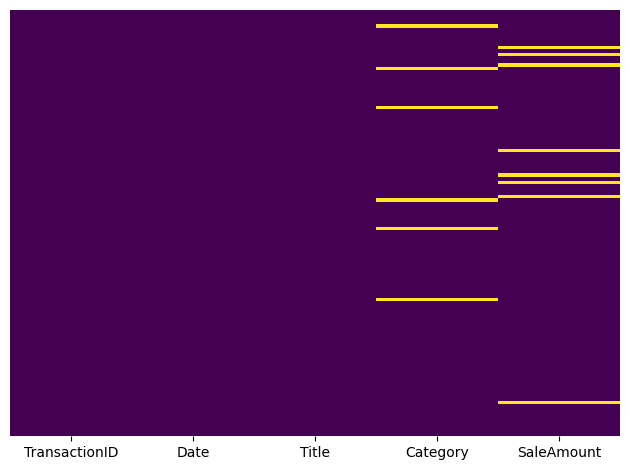

In [6]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.tight_layout()

We can see some missing data in `Category` and `SaleAmount`

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  120 non-null    object
 1   Date           120 non-null    object
 2   Title          120 non-null    object
 3   Category       114 non-null    object
 4   SaleAmount     112 non-null    object
dtypes: object(5)
memory usage: 4.8+ KB


In [8]:
def clean_data(data, column_to_drop_na):

    data = data.copy()
    
    # transactionID
    try:
        data['TransactionID'] = data['TransactionID'].astype('string').str.strip()
    except Exception:
        print("Error converting TransactionID columns to string.")
        return None

    n_blank_transaction = data['TransactionID'].eq('').sum()
    if n_blank_transaction:
        print(f'Warming! {n_blank_transaction} transactions are blank!')

    if 'TransactionID' in column_to_drop_na:
        data = data.dropna(subset=['TransactionID'])
        data = data[data['TransactionID'] != '']   #remove blanks as well
        print('Dropping rows where TransactionID is NA or empty')
        print('========================================\n')

    # date
    try:
        data['Date'] = pd.to_datetime(data['Date'])
    except Exception:
        print("Error converting Date columns to datetime.")
        return None

    if 'Date' in column_to_drop_na:
        data = data.dropna(subset=['Date'])
        print('Dropping rows where Date is NA')
        print('========================================\n')

    # Title
    try:
        data['Title'] = data['Title'].astype('string').str.strip()
    except Exception:
        print("Error converting Title columns to string.")
        return None

    n_blank_title = data['Title'].eq('').sum()
    if n_blank_title:
        print(f'Warming! {n_blank_title} titles are blank!')

    if 'Title' in column_to_drop_na:
        data = data.dropna(subset=['Title'])
        data = data[data['Title'] != '']   #remove blanks as well
        print('Dropping rows where Title is NA or empty')
        print('========================================\n')

    # Category
    try:
        data['Category'] = (
        data['Category']
        .astype('string')     # preserves real <NA>
        .str.strip()          # remove whitespace
        .replace({'': pd.NA}) # convert empty strings to NA
        )
    except Exception:
        print("Error converting Category columns to string.")
        return None

    n_blank_cat = data['Category'].eq('').sum()
    if n_blank_cat:
        print(f'Warming! {n_blank_cat} categories are blank!')

    if 'Category' in column_to_drop_na:
        data = data.dropna(subset=['Category'])
        data = data[data['Category'] != '']   #remove blanks as well
        data = data[data['Category'] != 'Unknown']
        data = data[data['Category'] != 'nan']
        print('Dropping rows where Category is NA or empty')
        print('========================================\n')

    # saleAmount

    data['SaleAmount'] = (
    data['SaleAmount'].astype(str)
    .str.replace(r'[^\d\.\-]', '', regex=True)     # allow minus
    .str.replace(r'(?<=.)-', '', regex=True)       # drop any minus not at the start
    )

    data['SaleAmount'] = pd.to_numeric(data['SaleAmount'], errors='coerce')

    median = data['SaleAmount'].median(skipna=True)

    data['SaleAmount'] = data['SaleAmount'].fillna(median)

    print(f'The median for SaleAmount was {median}')
    print('========================================\n')
    print('NAs filled with the median value')
    print('========================================\n')
    print('✅ Data successfully cleaned and processed!')
    print('========================================')

    return data

In [9]:
df = clean_data(df, column_to_drop_na= ['Category'])

Dropping rows where Category is NA or empty

The median for SaleAmount was 22.21

NAs filled with the median value

✅ Data successfully cleaned and processed!


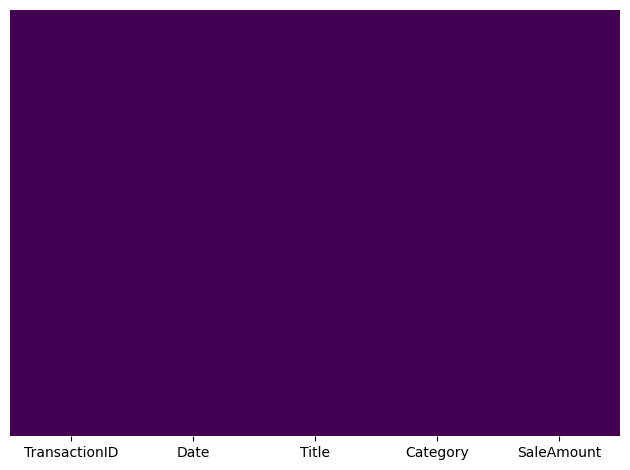

In [10]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.tight_layout()

## 3. Feature Engineering

In [19]:
df['RevenueTier'] = df['SaleAmount'].apply(
    lambda x: 'Low' if x < 20 else ('Medium' if x <= 50 else 'High')
)

In [20]:
df.head(10)

,TransactionID,Date,Title,Category,SaleAmount,RevenueTier
0,T0055,2025-10-25,Deep Workflows,Non-Fiction,23.03,Medium
1,T0007,2025-10-29,Moonlight Friends,Children,0.02,Low
2,T0026,2025-10-30,Queens and Quarrels,History,37.88,Medium
3,T0057,2025-10-05,The Last Orchard,Fiction,14.51,Low
5,T0096,2025-10-22,City of Masks #3,Comics,11.83,Low
7,T0025,2025-10-12,Queens and Quarrels,History,35.73,Medium
8,T0112,2025-10-23,Riftwalker #7,Comics,8.21,Low
9,T0075,2025-10-28,Sunlit Rooms,Poetry,22.69,Medium
10,T0005,2025-10-11,Riftwalker #7,Comics,22.21,Medium
11,T0102,2025-10-02,Habits of Insight,Non-Fiction,30.52,Medium


## 4. Reshape Data

In [13]:
r = df[['Category','SaleAmount','RevenueTier']].groupby(['Category','RevenueTier']).mean()

In [14]:
r

SaleAmount
Category    RevenueTier            
Children    Low            7.846923
            Medium        28.637500
Comics      Low            7.974545
            Medium        21.906667
Fiction     Low           -6.510000
            Medium        27.475833
History     Low          -27.612500
            Medium        29.385000
Non-Fiction Medium        30.606364
Poetry      Low            9.421667
            Medium        23.600000
Sci-Fi      Low           -0.520000
            Medium        28.308333

## 5. Visualise

In [17]:
summary = df.groupby('Category', as_index = False)['SaleAmount'].sum()

avg = df.groupby('Category', as_index = False)['SaleAmount'].mean().rename(columns={'SaleAmount': 'AvgSale'})

summary = pd.merge(summary, avg, how='left')

summary = summary.sort_values(by = 'SaleAmount')

summary

,Category,SaleAmount,AvgSale
1,Comics,153.44,10.960000
5,Poetry,174.53,15.866364
2,Fiction,290.65,16.147222
3,History,300.94,16.718889
0,Children,331.11,15.767143
4,Non-Fiction,336.67,30.606364
6,Sci-Fi,338.14,22.542667


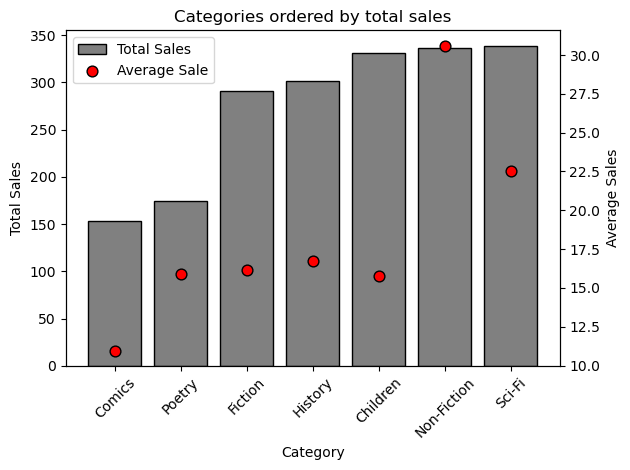

In [23]:
fig, ax1 = plt.subplots()

bars = ax1.bar(x = 'Category', 
        height = 'SaleAmount', 
        data = summary, 
        facecolor = 'grey', 
        edgecolor = 'black')
ax1.set_xlabel('Category')
ax1.set_ylabel('Total Sales')
ax1.tick_params(axis='x', labelrotation=45)


ax2 = ax1.twinx()  
points = ax2.scatter(summary['Category'], 
            summary['AvgSale'], 
            color='red', 
            marker = 'o', 
            s = 60, 
            edgecolor = 'black')
ax2.set_ylabel('Average Sales')
ax1.legend([bars, points], ['Total Sales', 'Average Sale'], loc='upper left')
plt.title('Categories ordered by total sales')
plt.tight_layout()

# --- End of Challenge! ---